# Redes Neurais Recorrentes (RNNs)

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- RNNs;
- LSTM.

## 

# Introdução

Até agora, nós vimos diversos tipos de redes neurais, e elas podem ser utilizadas para diversos problemas. A partir de entradas, elas calculavam uma saída como previsão. 

Porém, um tipo de dados comuns de se trabalhar são os __sequenciais__, como séries temporais e textos.

<div>
<img src="https://www.tradingview.com/x/BIMmjLxL/" width=600 align="center"/>
</div>


<div>
<img src="attachment:image.png" width=600 align="center"/>
</div>

Nesse tipo de dados, os valores "passados" tem forte relação com os valores "futuros", algo que não está explícito nas arquiteturas que vimos até aqui. Para tentar explicitar isso, vamos usar __redes neurais recorrentes__.

## 

# Redes Neurais Recorrentes (RNNs)

Nas __redes neurais recorrentes__, a saída de uma camada escondida também funciona como a entrada dessa mesma camada escondida! 

<div>
<img src = "https://www.deeplearningbook.com.br/wp-content/uploads/2019/07/rnn.png" width=600>
<div>

Mas como funciona isso? Imagina que a saída em um dado passo de tempo é a entrada no passo de tempo seguinte.
<br><br>
<div>
<img src="https://www.deeplearningbook.com.br/wp-content/uploads/2019/08/RNN-unrolled-1024x269.png" width=600>
</div>

Pode-se entender a rede neural recorrente como uma combinação de redes neurais em sequência, dessa forma as previsões levam em considerar o que foi passado anteriormente. As RNNs mais tradicionais podem apresentar um problema de dependência ao longo prazo, ou seja o intervalo de dados anteriores que seja preciso para fazer as próximas predições seria muito grandes, o que inviabiliza o desenvolvimento da RNN.

<br>

Uma forma de evitar este tipo de problema seria justamente utlizar de RNNs que tenha a capacidade de armazenamento de memória, garantindo que seja repassado dependências de longo prazo, uma dessas redes é a __Long Short Time Memory (LSTM).__

<img src="https://miro.medium.com/max/875/0*z_7CtCBqX5OycQx4.png" width = 600>

Não vamos entrar no detalhe de como a LSTM faz esse armazenamento de fato, mas para mais detalhes, têm este [artigo](https://medium.com/@web2ajax/redes-neurais-recorrentes-lstm-b90b720dc3f6) do _Medium_ detalhando todo o processo.

A seguir vamos ver ,um exemplo de aplicação utlizando a _LSTM_ em NLP e em Séries Temporais.

## 

### Exemplo aplicado a NLP

Utilizando a base de dados sobre notificações de desastres pelo _Twitter_ `tweet.csv` e vamos desenvolver os seguintes tópicos abaixo:

__A)__ Crie uma função para fazer o preprocessing da base `tweet.csv` e uma função para aplicar o TF-IDF;

__B)__ Crie uma função que teste diversos modelos de Classificação como por exemplo: Regressão Logística, Árvore de Decisão, RandomForest e AdaBoost. Além disso, para cada modelo plote as principais métricas e por fim plote uma curva ROC-AUC. Teste os Modelos

__C)__ Desenvolva uma Rede Neural Embedding com LSTM para fazer a classificação dos tweets. Qual a rede neural teve uma performance melhor que o modelo tradicional?


### Resolução:

In [1]:
# Imports utilizados em todos os exercícios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow

# Libs para NLP
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.stem import SnowballStemmer
import re

# Libs de Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_confusion_matrix

# Libs para Redes Neurais
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import Callback, EarlyStopping

# Import da biblioteca warnings para ignorar eventuais warnings
import warnings
warnings.filterwarnings('ignore')

2022-09-30 20:12:13.104549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package punkt to /home/Faaeel06/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/Faaeel06/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /home/Faaeel06/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


ImportError: cannot import name 'pad_sequences' from 'keras.preprocessing.sequence' (/home/Faaeel06/.local/lib/python3.9/site-packages/keras/preprocessing/sequence.py)

__A)__ Crie uma função para fazer o preprocessing da base `tweet.csv` e uma função para aplicar o TF-IDF;

In [ ]:
tweets = pd.read_csv('../datasets/tweets.csv')
tweets

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
tweets['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
stopwords = set(stopwords.words('english'))
Stemmer = PorterStemmer()

def preprocessing(string):

    string = re.sub(r"[^a-zA-Z0-9]+", ' ', string)

    string = string.lower()

    words = word_tokenize(string)
    stem_words = []
    filtered_words = []
    for w in words:
        if w not in stopwords:
            s_words = Stemmer.stem(w)
            stem_words.append(s_words)
    
    return stem_words

AttributeError: 'set' object has no attribute 'words'

In [ ]:
tweets['filtered_words'] = tweets['text'].apply(lambda x: preprocessing())

NameError: name 'preprocessing' is not defined

__B)__ Crie uma função que teste diversos modelos de Classificação como por exemplo: Regressão Logística, Árvore de Decisão, RandomForest e AdaBoost. Além disso, para cada modelo plote as principais métricas e por fim plote uma curva ROC-AUC. Teste os Modelos

In [ ]:
tfidf = TfidfVectorizer(use_idf = True)

__C)__ Desenvolva uma Rede Neural Embedding com LSTM para fazer a classificação dos tweets. Qual a rede neural teve uma performance melhor que o modelo tradicional?

Resultado para o Embedding com LSTM ficou bem próximo do resultado obtido para a melhor combinação de modelo com o TF-IDF, mostrando o potencial de desenvolvimento de uma rede neural.

## 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter

### Exemplo aplicado a Séries Temporais

Use a base de dados `covid_saopaulo.csv` para desenvolver uma rede dinâmica LSTM e faça predições das mortes usando um trecho da série temporal de 21 dias.

### Resolução:

## 

## Exercícios

__1)__ Replique o exercício dos casos de COVID em São Paulo para

In [ ]:
covidsp = pd.read_csv('../datasets/covid_saopaulo.csv',
                        index_col='date',
                        parse_dates= True)

In [ ]:
covidsp

,confirmed,deaths
date,,
2020-02-26,0,0
2020-02-27,0,0
2020-02-28,1,0
2020-02-29,0,0
2020-03-01,0,0
...,...,...
2020-12-26,1253,13
2020-12-27,2836,55
2020-12-28,1576,39


In [ ]:
#Index com todas as datas possíveis

idx = pd.date_range(start = covidsp.index.min(),
                    end = covidsp.index.max(),
                    freq = 'D')

In [ ]:
idx

DatetimeIndex(['2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06',
               ...
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', length=309, freq='D')

In [ ]:
covidsp = covidsp.reindex(idx)

In [ ]:
covidsp.drop('confirmed', axis=1, inplace=True)

In [ ]:
covidsp.isna().sum()

deaths    7
dtype: int64

In [ ]:
covidsp[covidsp['deaths'].isna() == True]

,deaths
2020-03-13,NaN
2020-03-15,NaN
2020-11-06,NaN
2020-11-07,NaN
2020-11-08,NaN
2020-11-09,NaN
2020-12-16,NaN


In [ ]:
# Preeencher os dias faltantes com 0

covidsp.fillna(0, inplace=True)

<AxesSubplot: >

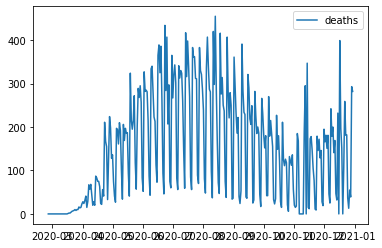

In [ ]:
sns.lineplot(covidsp)

In [ ]:
# Pre Processing

In [ ]:
#Tamanho da base
len(covidsp)

309

In [ ]:
#Tirando os 21 dias de teste
len(covidsp) - 21

288

In [ ]:
#separando em treino e teste
train = covidsp.iloc[:288]
test = covidsp.iloc[288:]

In [ ]:
train.shape, test.shape

((288, 1), (21, 1))

In [ ]:
# Mudando a escala dos nossos dados
from sklearn.preprocessing import MinMaxScaler

# Instanciar o scaler

scaler = MinMaxScaler()

# Transformar os dados
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.0021978 ],
       [0.0043956 ],
       [0.0043956 ],
       [0.00879121],
       [0.01318681],
       [0.01538462],
       [0.01758242],
       [0.02197802],
       [0.01758242],
       [0.02197802],
       [0.02197802],
       [0.03516484],
       [0.03076923],
       [0.03296703],
       [0.05054945],
       [0.06153846],
       [0.05274725],
       [0.06813187],
       [0.09010989],
       [0.03296703],
       [0.06373626],
       [0.14725275],
       [0.12527473],
       [0.14945055],
       [0.0967033 ],
       [0.04395604],
       [0.06153846],
       [0.043

In [ ]:
# Gerar os pacotes ou lotes (ou batch)
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# Parâmetros dos pacotes
n_input = 7
n_features = 1

# Definindo o generator

generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 2)

In [ ]:
X, y = generator[0]

In [ ]:
print('Dados esperados por lote e previsão')
print(f'Primeiro lote: \n {X.flatten()}')
print(f'Previsão: {y}')

Dados esperados por lote e previsão
Primeiro lote: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Previsão: [[0.]
 [0.]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
model.compile(optimize = 'adam', loss='mse')

TypeError: Invalid keyword argument(s) in `compile()`: ({'optimize'},). Valid keyword arguments include "cloning", "experimental_run_tf_function", "distribute", "target_tensors", or "sample_weight_mode".